In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

torch.manual_seed(42)
np.random.seed(42)

In [3]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.bn5 = nn.BatchNorm2d(num_features=128)
        self.bn6 = nn.BatchNorm2d(num_features=128)
        self.dropout3 = nn.Dropout(p=0.4)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=2048, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.bn7 = nn.BatchNorm1d(num_features=128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=128, out_features=10)
        
        
    def forward(self, x):
        outputs = []
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        outputs.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        outputs.append(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        outputs.append(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        outputs.append(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)
        outputs.append(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        outputs.append(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.bn7(x)
        x = self.dropout4(x)
        scores = self.fc5(x)
        
        return scores, outputs

In [4]:
class IndividualEEModel(nn.Module):
    def __init__(self, in_features):
        super(IndividualEEModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [5]:
class GeneralEEModel(nn.Module):
    def __init__(self):
        super(GeneralEEModel, self).__init__()
        self.avg_ = nn.AvgPool2d(kernel_size=2)
        self.upsample_1 = nn.Upsample(scale_factor=2)
        self.upsample_2 = nn.Upsample(scale_factor=4)
        
        self.conv1x1 = nn.Conv2d(in_channels=320, out_channels=16, kernel_size=1, padding="same")
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, padding="same")
        
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=64)
#         self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=1024, out_features=10)
    
    def forward(self, x):
        resized_outputs = []
        resized_outputs.append(self.avg_(x[0]))
        resized_outputs.append(x[1])
        resized_outputs.append(x[2])
        resized_outputs.append(self.upsample_1(x[3]))
        resized_outputs.append(self.upsample_1(x[4]))
#         resized_outputs.append(self.upsample_2(x[5]))
        x = torch.cat(resized_outputs, dim=1)
        x = self.conv1x1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn1(x)
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.bn2(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.bn3(x)
        x = self.flatten(x)
        scores = self.fc1(x)
        return scores

In [6]:
def simulate_exit(x, choice=None):
    if choice is not None:
        choice = choice
    else:
        choice = np.random.choice(np.arange(0, 5), p=[.2]*5)
    batch_size = x[0].shape[0]
    reshaped_output = []
    for i in range(5):
        if i <= choice :
            reshaped_output.append(x[i])
        else:
            reshaped_output.append(torch.zeros_like(x[i]))
    return reshaped_output, choice

In [7]:
def train(baseline, exit_model, layer, epochs, criterion, 
          optimizer, train_loader, val_loader, model_name, gen_ee=False):
    best_val_epoch, best_val_loss = 0, 1e6
    break_flag = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        exit_model.train()
        t_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            t_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_loss = t_loss / (i+1)
        t_loss = round(t_loss, 5)
        t_acc = round(100*(correct / total), 5)
        exit_model.eval()
        v_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        v_loss = v_loss/(i+1)
        v_loss = round(v_loss, 5)
        v_acc = round(100*(correct / total), 5)
        if v_loss <= best_val_loss:
            torch.save(exit_model.state_dict(), model_name)
            best_val_epoch = epoch + 1
            best_val_loss = v_loss
            break_flag = 0
        else:
            break_flag += 1
        print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
        if break_flag >19 :
            break
    print('Finished Training')
    print('Best model saved at epoch: ', best_val_epoch)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
dataset = CIFAR10(root='./data', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='./data', train=False, transform=ToTensor())

Files already downloaded and verified


In [10]:
batch_size=128
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4)

In [11]:
baseline = Baseline().to(device)
baseline.load_state_dict(torch.load("cifar10_baseline_m.h5", map_location='cpu'))
ee_model_name = "cifar10_ee_m.h5"
baseline.eval()

Baseline(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [12]:
in_features = []
m = nn.MaxPool2d(kernel_size=2)
f = nn.Flatten()
_, outs = baseline(torch.randn(2, 3, 32, 32).to(device))
for out in outs[:-1]:
    xx = f(m(out))
    in_features.append(xx.shape[1])

In [13]:
result_dict = {}
result_dict["accuracy"] = []
for ii, in_feature in enumerate(in_features):
    print(f'Training for exit layer: {ii+1}')
    precisions, recall, f1 = [], [], []
    learning_rate = 1e-3
    exit_model = IndividualEEModel(in_features=in_feature).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=1e-3, momentum=0.9)
    epochs = 50
    ee_model_name = "ind_ee_cifar10_m.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, train_loader, val_loader, ee_model_name)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            outputs = exit_model(outs[ii])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

Training for exit layer: 1


Epoch[1]: t_loss: 1.45753 t_acc: 49.05778 v_loss: 1.28327 v_acc: 56.4
Epoch[2]: t_loss: 1.19976 t_acc: 58.36 v_loss: 1.20612 v_acc: 57.84
Epoch[3]: t_loss: 1.09813 t_acc: 61.71778 v_loss: 1.20674 v_acc: 58.3
Epoch[4]: t_loss: 1.04283 t_acc: 64.02889 v_loss: 1.24756 v_acc: 57.8
Epoch[5]: t_loss: 0.9886 t_acc: 65.89333 v_loss: 1.16434 v_acc: 59.74
Epoch[6]: t_loss: 0.95691 t_acc: 66.71111 v_loss: 1.16347 v_acc: 59.88
Epoch[7]: t_loss: 0.93245 t_acc: 67.53778 v_loss: 1.19378 v_acc: 59.3
Epoch[8]: t_loss: 0.90459 t_acc: 68.61778 v_loss: 1.14274 v_acc: 60.86
Epoch[9]: t_loss: 0.8858 t_acc: 69.33778 v_loss: 1.13943 v_acc: 61.16
Epoch[10]: t_loss: 0.87867 t_acc: 69.63333 v_loss: 1.17612 v_acc: 60.2
Epoch[11]: t_loss: 0.85485 t_acc: 70.25333 v_loss: 1.1903 v_acc: 59.86
Epoch[12]: t_loss: 0.83634 t_acc: 71.04889 v_loss: 1.17708 v_acc: 60.52
Epoch[13]: t_loss: 0.81397 t_acc: 71.67111 v_loss: 1.15038 v_acc: 61.46
Epoch[14]: t_loss: 0.80351 t_acc: 72.13556 v_loss: 1.18024 v_acc: 60.4
Epoch[15]: t_

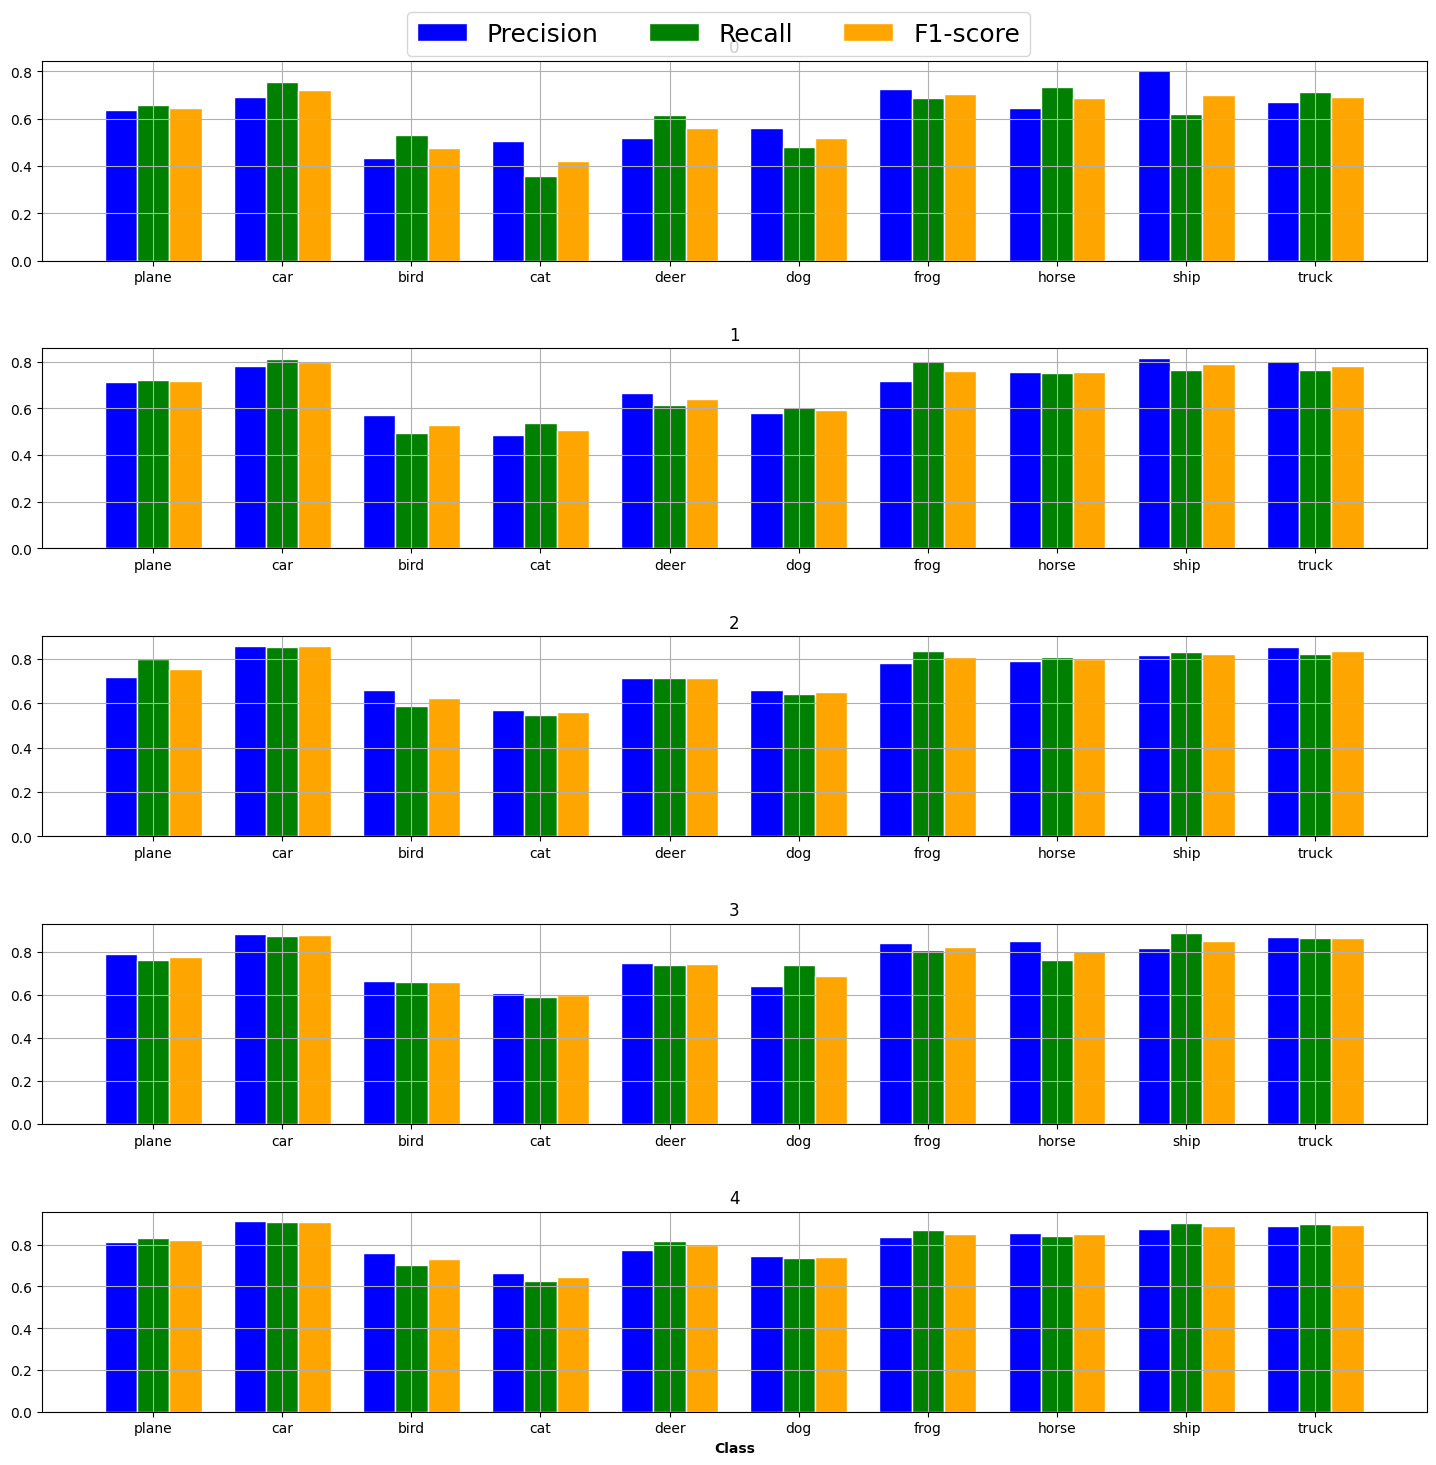

In [14]:
fig, axes = plt.subplots(len(in_features), 1, figsize=(15, 15))
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
axes = axes.ravel()
bar_width = 0.25
for i, ax in enumerate(axes):
    precisions = result_dict[i]['precision']
    recall = result_dict[i]['recall']
    f1 = result_dict[i]['f1']
    r1 = np.arange(len(precisions))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
    ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
    ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
    ax.set_title(str(i))
    ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
    ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [15]:
ind_accuracies = []
for i, accuracy in enumerate(result_dict['accuracy']):
    accuracy = round(accuracy, 4)
    precision = round(np.mean(result_dict[i]["precision"]), 4)
    recall = round(np.mean(result_dict[i]["recall"]), 4)
    f1 = round(np.mean(result_dict[i]["f1"]), 4)
    ind_accuracies.append(accuracy)
    print(f'Layer {i+1}: Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | f1-score: {f1}')    

Layer 1: Accuracy: 0.6145 | Precision: 0.6198 | Recall: 0.6145 | f1-score: 0.6129
Layer 2: Accuracy: 0.6877 | Precision: 0.6893 | Recall: 0.6877 | f1-score: 0.6876
Layer 3: Accuracy: 0.7443 | Precision: 0.7428 | Recall: 0.7443 | f1-score: 0.7429
Layer 4: Accuracy: 0.7695 | Precision: 0.7718 | Recall: 0.7695 | f1-score: 0.7698
Layer 5: Accuracy: 0.8139 | Precision: 0.8125 | Recall: 0.8139 | f1-score: 0.8129


In [16]:
torch.manual_seed(42)
np.random.seed(42)


result_dict = {}
result_dict["accuracy"] = []
in_features = [0]
for ii, in_feature in enumerate(in_features):
    precisions, recall, f1 = [], [], []
    learning_rate = 5e-3
    exit_model = GeneralEEModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=learning_rate, momentum=0.9)
    epochs = 100
    ee_model_name = "gen_ee_cifar10_m_5.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, 
          train_loader, val_loader, ee_model_name, gen_ee=True)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            outputs = exit_model(outs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

Epoch[1]: t_loss: 1.1572 t_acc: 59.23333 v_loss: 1.76321 v_acc: 52.66
Epoch[2]: t_loss: 0.90521 t_acc: 68.40889 v_loss: 1.36331 v_acc: 56.42
Epoch[3]: t_loss: 0.85002 t_acc: 70.43111 v_loss: 1.44431 v_acc: 58.22
Epoch[4]: t_loss: 0.81072 t_acc: 71.84 v_loss: 1.19178 v_acc: 61.28
Epoch[5]: t_loss: 0.79961 t_acc: 72.17333 v_loss: 1.19852 v_acc: 63.16
Epoch[6]: t_loss: 0.7754 t_acc: 72.68 v_loss: 1.64514 v_acc: 52.32
Epoch[7]: t_loss: 0.76479 t_acc: 73.43111 v_loss: 1.39257 v_acc: 59.12
Epoch[8]: t_loss: 0.76216 t_acc: 73.39111 v_loss: 1.30775 v_acc: 60.72
Epoch[9]: t_loss: 0.75452 t_acc: 73.71556 v_loss: 1.32924 v_acc: 61.06
Epoch[10]: t_loss: 0.74644 t_acc: 74.01333 v_loss: 1.26084 v_acc: 61.46
Epoch[11]: t_loss: 0.73919 t_acc: 74.07556 v_loss: 1.38194 v_acc: 58.4
Epoch[12]: t_loss: 0.7534 t_acc: 73.78222 v_loss: 1.31025 v_acc: 61.92
Epoch[13]: t_loss: 0.72528 t_acc: 74.71111 v_loss: 1.49486 v_acc: 56.46
Epoch[14]: t_loss: 0.72986 t_acc: 74.50667 v_loss: 1.12041 v_acc: 64.02
Epoch[15]: 

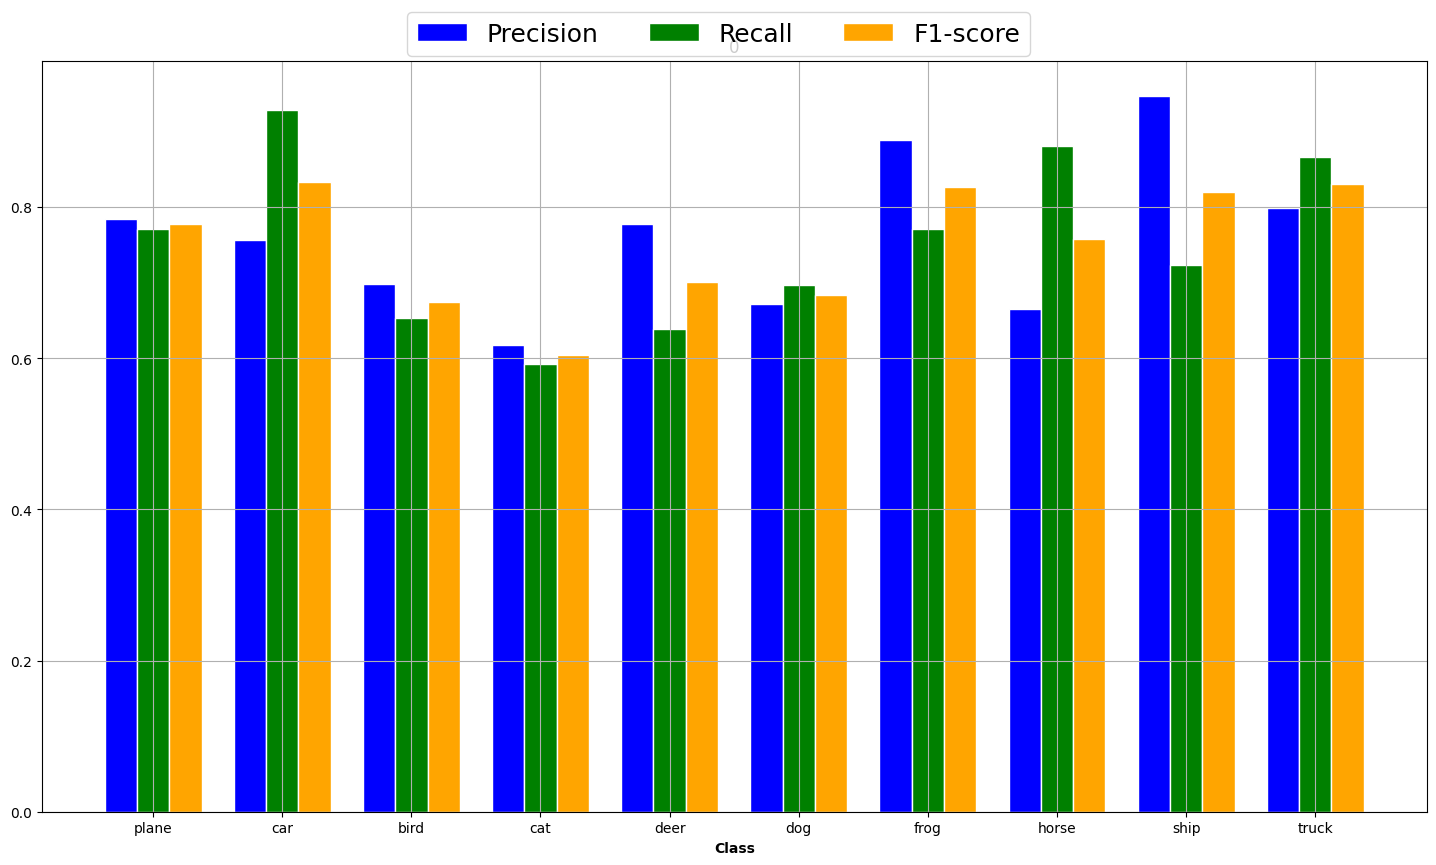

In [17]:
fig, ax = plt.subplots(len(in_features), 1, figsize=(15, 9))
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bar_width = 0.25
i = 0
precisions = result_dict[i]['precision']
recall = result_dict[i]['recall']
f1 = result_dict[i]['f1']
r1 = np.arange(len(precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
ax.set_title(str(i))
ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [18]:
accuracies = []
for choice in range(5):
    true_y, pred_y = [], []
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        _, outs = baseline(images)
        outs, _ = simulate_exit(outs, choice=choice)
        outputs = exit_model(outs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_y = pred_y + list(predicted.detach().cpu().numpy())
        true_y = true_y + list(labels.detach().cpu().numpy())
    report = classification_report(true_y, pred_y, output_dict=True)
    accuracies.append(report["accuracy"])
    print(f'Layer: {choice+1} | Accuracy: {report["accuracy"]}')

Layer: 1 | Accuracy: 0.27


/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 2 | Accuracy: 0.5353
Layer: 3 | Accuracy: 0.7146
Layer: 4 | Accuracy: 0.7118
Layer: 5 | Accuracy: 0.752


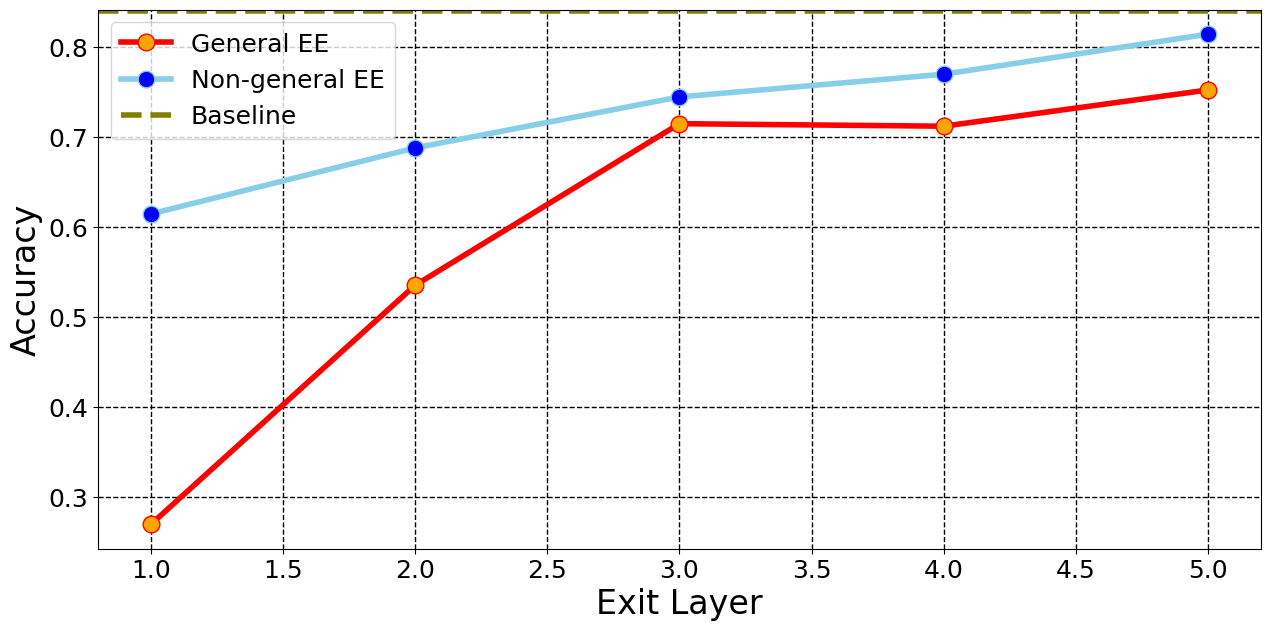

In [19]:
plt.figure(figsize=(15, 7))
x = [1, 2, 3, 4, 5]
plt.plot(x, accuracies, 
         marker='o', markerfacecolor='orange', markersize=12, color='red', linewidth=4,
         label="General EE"
        )
plt.plot(x, ind_accuracies, 
         marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,
         label="Non-general EE"
        )
plt.axhline(0.84, marker='', color='olive', linewidth=4, linestyle='dashed', label="Baseline")
plt.xlabel("Exit Layer", fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(color='k', linestyle='--', linewidth=1)
plt.legend(loc="best", prop={'size': 18})
plt.show()